## Simulations of contrast with both Greedy Guess and Least Square droplet algo
New simulations ideas : combining the negative binomial with random hits (photons postions) inside the speckles

We want to quantify the precision in extractged contrast for the Greedy Guess and the Least Square with a judicious simulation:

1. Produce a Negative Binomial PhotonMap distribution
2. Blow up this PhotonMap by a multiplicator factor (in this case the bining factor, e.g., 16 )
3. Attribute a number of random photon position within this oversample blown up pixel, proportional to the pixel P(k) 
4. Convolve this new Map with Gaussian 
5. Bin this PhotonMap back to its original size 
6. Add Gaussian noise to the PhotonMap

Step 2-5 are actually used to get subpixel accuracy on the photonspread positions. 

The contrast should altogether be extracted at after step 1, 5 and 6 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
import os
from pathlib import Path
import time
import seaborn as sns


import scipy.ndimage as ndimage
from scipy import optimize
from scipy import signal
from psana import *
import psana as ps

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from scipy.special import gamma, factorial
from lmfit import Model
# from random import choices

plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (20, 8)

import ImgAlgos.PyAlgos

import waveform_processing as proc
reload(proc)

<module 'waveform_processing' from 'waveform_processing.pyc'>

# Step 1. Define a negative binomial distribution function (based on Charle's and Vincent's)

In [95]:
def Generate_samples(nShot, maxPhoton, SingleContrast, kave_range,im_size, axis=0):
       
    contrasts = []
    start = time.time()
    simu_speckle_patterns = []


    for jj in range(nShot):

        if SingleContrast:
            contrast = 0.7
        else:
            contrast = np.random.randint(1,high=10,size=1)/10.

        M = contrast**-2
        kave_max = kave_range[0] + (kave_range[1]-kave_range[0])*np.random.rand(1)
        I0 = kave_max
        int_distrib = np.transpose(np.ones(im_size))
        kave_img = np.multiply.outer(kave_max, int_distrib) # map of kave according to the intensity distribution 
        prob=[]

        for k in range(maxPhoton):
            y1 = (gamma(k+M)/gamma(M))*factorial(k)
            y2 = (kave_img.ravel()/(kave_img.ravel()+M))**k
            y3 = (M/(kave_img.ravel()+M))**M
            Pkk=y1*y2*y3
            prob.append(Pkk)

        prob = np.asarray(prob)
        r = np.expand_dims(np.random.rand(prob.shape[1]), axis=axis)
        simu_speckle_pattern = (prob.cumsum(axis=axis) > r).argmax(axis=axis)
        simu_speckle_pattern = np.squeeze( np.asarray(simu_speckle_pattern.reshape(kave_img.shape)))
        simu_speckle_patterns.append(simu_speckle_pattern)
        contrasts.append(contrast)

    simu_images = np.asarray(simu_speckle_patterns)
   # simu_images = simu_images.reshape( simu_images.shape[0], im_size[0], im_size[1]).astype('float32')
    contrasts = np.asarray(contrasts)
    plt.figure(figsize=(20,12))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    #cmap = sns.dark_palette("purple", as_cmap = True)
    
    for i in range(0,9):
        rd = np.random.randint(0,nShot-1)
        plt.subplot(3, 3, i+1)
        plt.title('CONTRAST={}'.format( str(contrasts[rd] ) ) )
        plt.imshow(simu_images[rd, :, :] , cmap='inferno' )
        #plt.colorbar()
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    end = time.time()
    print('It took {0:.0f}s to generate {1} speckle patterns with a max photon count of {2}'.format(end-start, str(nShot),str(maxPhoton)))

    return [simu_images, contrasts]

# select real samples

# Step 1.a. Simulate a negative binomial distribution with the following parameters:

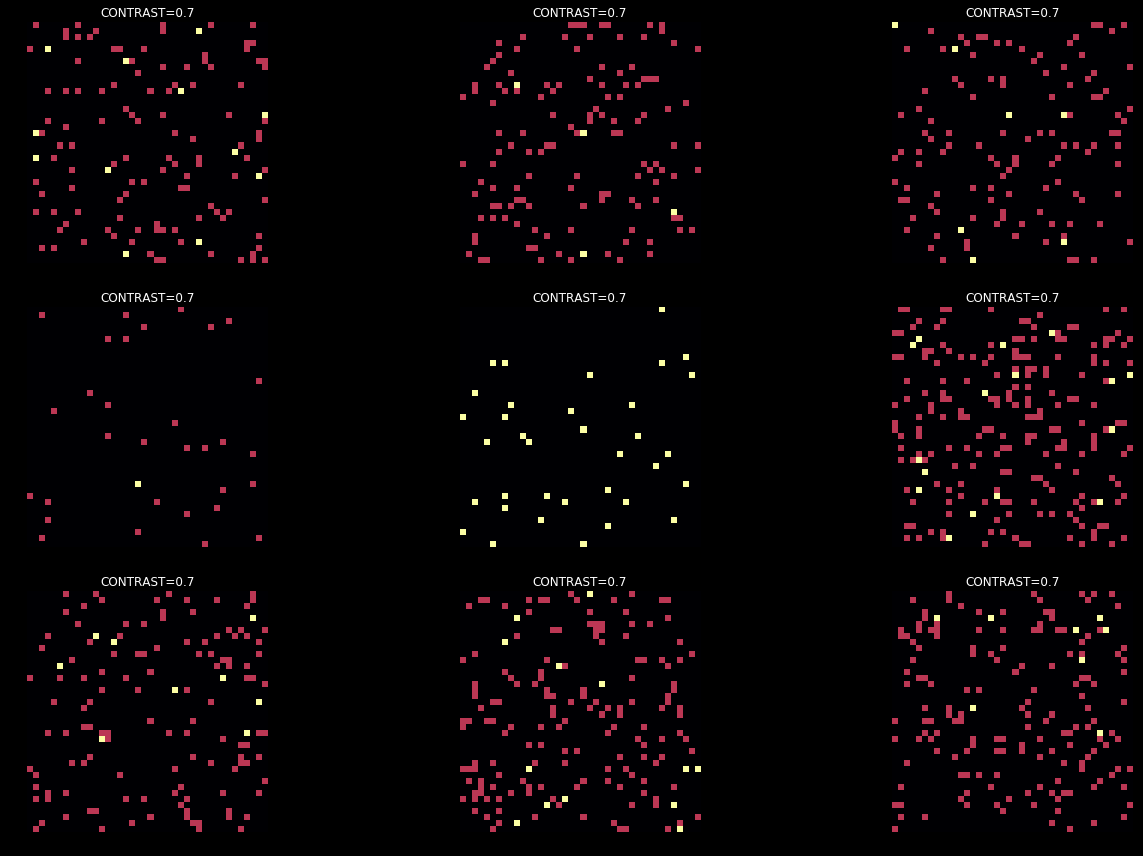

It took 1s to generate 100 speckle patterns with a max photon count of 20


In [96]:
maxPhoton = 20
nShot = 100
SingleContrast = 'True'
kave_range = [0.01,0.15]
im_size = (40,40)
[simu_speckles, contrasts] = Generate_samples(nShot,maxPhoton,SingleContrast, kave_range, im_size)

# Defining in order the vital functions for the simulations : 

The GaussianKernel function is used to produce a Gaussian representation of the photon distribution. From experimental finding, the sigma is ~0.5, so in this simulation we oversample sigma by binning of 16. 

The PixelReshape function is used to select the indivdual pixel within the oversampled detector. The built-in reshape function does not do the same job or it could be adapted to this aim ??

The RandPositions function checks the value k of the blow-up pixel and introduces a similar number of random positions within it boundaries. 

The PixelReshapeBack function is used to reconstitute the detector array after injecting the random photon positions within the blown-up pixels !

The binning2d function bins back the oversampled PhotonMap 



In [97]:
def GaussianKernel(Dim, Pos, photonSize, ADU):
    xx = np.linspace(0,Dim[0]-1, Dim[1])
    yy = np.linspace(0,Dim[0]-1, Dim[1])
    xx,yy = np.meshgrid(xx,yy)
    G_kernel = ADU*np.exp(-(np.abs(xx-Pos[1])**2 + np.abs(yy-Pos[0])**2) / photonSize**2)
    G_kernel = G_kernel * ADU / np.sum(G_kernel)
    #G_kernel[G_kernel<10] = 0
    return G_kernel

def PixelReshape(imIn, binXY):
    # get shape
    N, M = imIn.shape
   
    Pieces = np.zeros( ( (M*N)/binXY**2, binXY, binXY) )
    conter = 0
    for i in range(N/binXY):
        for j in range(M/binXY):
            Pieces[conter] = imIn[i*binXY:(i+1)*binXY,j*binXY:(j+1)*binXY]     
            conter += 1

    return Pieces

def RandPositions(Arr):
        
        N, M = Arr.shape
        ArrayRand = np.zeros((N,M))
        number = Arr[0,0]
        if number  > 0:   
            
            for ll in range(int(number)):
                
                PositionalX = np.random.randint(0, high=M, size= 1)
                PositionalY = np.random.randint(0, high=N, size= 1)
                ArrayRand[PositionalY, PositionalX] = 1    
                
            return ArrayRand

def PixelReshapeBack(imIn, binXY):
    # get shape
    L, M, N = imIn.shape
   
    Matrice = np.zeros( ( L**0.5*binXY, L**0.5*binXY ) )
    conter = 0
    for i in range(int(L**0.5)):
        for j in range(int(L**0.5)):
            Matrice[i*binXY:(i+1)*binXY,j*binXY:(j+1)*binXY] =  imIn[conter]
            conter += 1

    return Matrice
 
def binning2d(imIn, binX, binY ):
    # get shape
    N, M = imIn.shape
    N0, M0 = imIn.shape
    
    while N%binY !=0: N=N+1 
    while M%binX !=0: M=M+1 
    #imIn = np.pad( imIn, ( N-N0,M-M0 ), 'constant', constant_values=(0))

    imOut = np.zeros((N/binY,M/binX))

    for i in range(N/binY):
        for j in range(M/binX):
            imOut[i,j] = np.sum(imIn[i*binY:(i+1)*binY,j*binX:(j+1)*binX] )

    return imOut

Making sure these functions work !! 

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.5.2/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


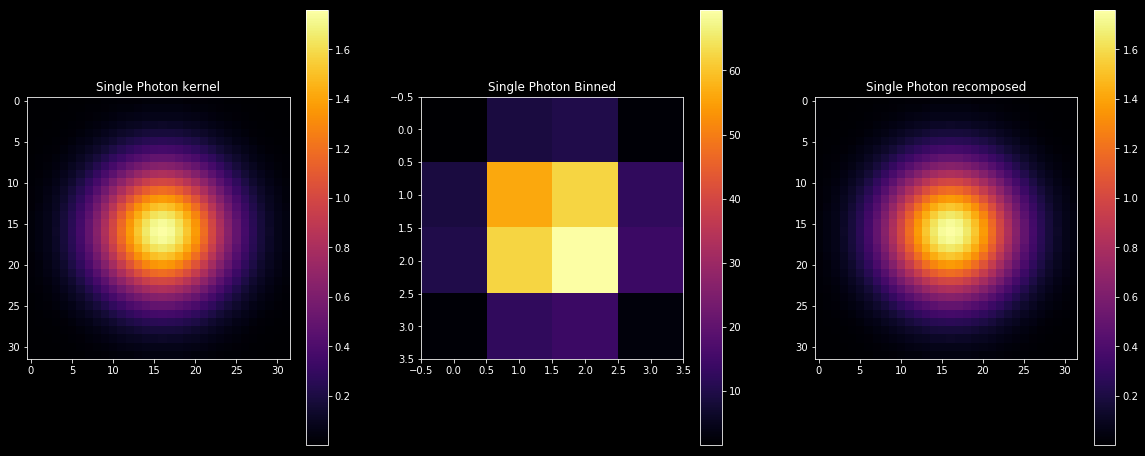

In [8]:
PhotonSig = 0.5    
photonADU = 350
Bin = 16
photonSize = Bin*PhotonSig
DimBinomial= simu_speckles.shape
Dim = [Bin*DimBinomial[1], Bin*DimBinomial[2]]

Center = [Bin, Bin]
SinglePhoton = GaussianKernel( [Bin*2, Bin*2], Center, photonSize, photonADU)
SinglePhotonBin = binning2d( SinglePhoton, Bin/2, Bin/2 )

Decompose = PixelReshape(SinglePhoton, Bin)
Recompose = PixelReshapeBack(Decompose, Bin)

plt.subplot(1,3,1)
plt.imshow( SinglePhoton, 'inferno' )
plt.title('Single Photon kernel')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow( SinglePhotonBin, 'inferno' )
plt.title('Single Photon Binned')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(Recompose, 'inferno' )
plt.title('Single Photon recomposed')
plt.colorbar()
plt.show()


Center = [Bin, Bin]
SinglePhoton = GaussianKernel( [Bin*2, Bin*2], Center, photonSize, photonADU)

In [98]:
Blown_speckles_Map = []
PhotonMapping = []
Blown_speckles_convos = []
PositionsMap = []
Blown_speckle_positions = []
Listing = np.arange(DimBinomial[1]*DimBinomial[2])
start = time.time()

for jj in range(simu_speckles.shape[0]):
    
    Blown_speckle_speckle = PixelReshape( simu_speckles[jj].repeat(Bin,0).repeat(Bin,1), Bin )
    
    for ss in  range(Blown_speckle_speckle.shape[0]):
        
        number = Blown_speckle_speckle[ss,0,0]
        if number  > 0:   
            
            ArrayRand = np.zeros((Bin,Bin))
            for ll in range(int(number)):
                
                PositionalX = np.random.randint(0, high=Bin, size= 1)
                PositionalY = np.random.randint(0, high=Bin, size= 1)
                ArrayRand[PositionalY, PositionalX] = 1    
                
            Blown_speckle_speckle[ss] = ArrayRand   
    
    #Blown_speckle_speckles = [RandPositions(Blown_speckle_speckle[List]) for List in Listing ]
    Blown_speckle_pos = PixelReshapeBack( Blown_speckle_speckle, Bin)
    
    Blown_speckles_convo = signal.convolve2d( Blown_speckle_pos, SinglePhoton, mode='same') 
    PhotonMapping.append( binning2d( Blown_speckles_convo, Bin, Bin))
    
    if jj < 10:
        Blown_speckles_convos.append(  Blown_speckles_convo )
        Blown_speckle_positions.append( Blown_speckle_pos )
        
        
PhotonMapping= np.asarray( PhotonMapping )
Blown_speckles_convo = np.asarray(  Blown_speckles_convo )
Blown_speckle_positions = np.asarray( Blown_speckle_positions )
end = time.time()
print('It took '+ str(end-start)+' to process ' +str(jj+1)+' PhotonMaps' )

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.5.2/lib/python2.7/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


It took 123.04087019 to process 100 PhotonMaps


Plotting the different simulated PhotonMaps

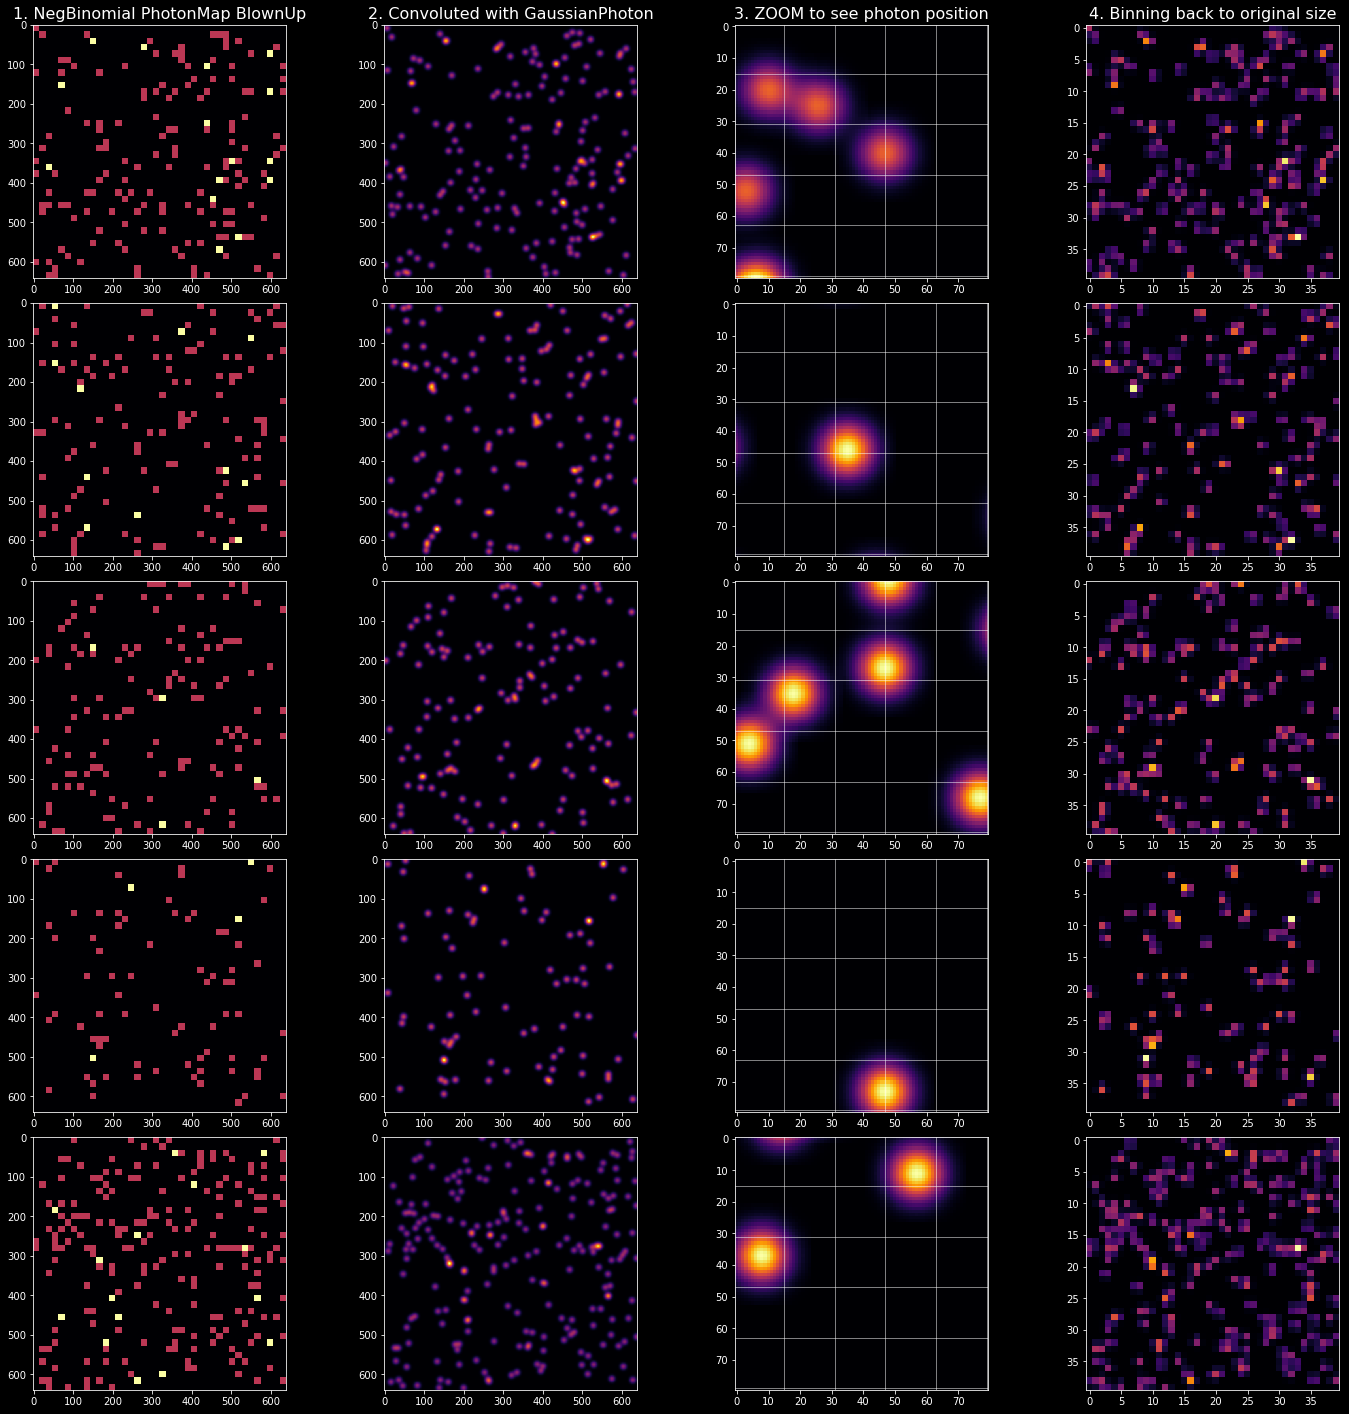

In [99]:
# Setup the scatter plots
from matplotlib.gridspec import *
cmap = sns.dark_palette("purple", as_cmap = True)


lines = np.arange(Bin-1,Dim[0]-Bin, Bin)
Pixels = np.arange(Bin-1,Dim[0]-Bin, Bin)
fig = plt.figure(figsize=(20,20))
grid = GridSpec(5, 4)
cc = 0
gg = 0

for jj in range(5):
    
    # Plot the photons
    ax = fig.add_subplot(grid[gg, cc])
    ax.imshow( simu_speckles[jj].repeat(Bin,0).repeat(Bin,1) , cmap = 'inferno' )
    if gg==0: ax.set_title('1. NegBinomial PhotonMap BlownUp', fontsize=16)
    
    cc += 1
    ax = fig.add_subplot(grid[gg, cc])
    ax.imshow( Blown_speckles_convos[jj] , cmap = 'inferno' )
    if gg==0: ax.set_title('2. Convoluted with GaussianPhoton', fontsize=16)
    
    cc += 1
    ax = fig.add_subplot(grid[gg, cc])
    for line in lines:
        ax.axvline( x=line, color='white', linewidth=0.5) 
        ax.axhline( y=line, color='white', linewidth=0.5) 
    ax.imshow(  Blown_speckles_convos[jj][64:144,64:144] , cmap = 'inferno' )
    if gg==0: ax.set_title('3. ZOOM to see photon position', fontsize=16)
        
    ax = fig.add_subplot(grid[gg, cc+1])
    ax.imshow( PhotonMapping[jj] , cmap='inferno')
   # ax.scatter( PositionsMap[jj][1,:] ,  PositionsMap[jj][0,:], marker='o',c='white',s=3 )
    if gg==0: ax.set_title('4. Binning back to original size', fontsize=16)
        
    gg +=1
    cc = 0   

fig.tight_layout(pad=2)
fig.subplots_adjust(wspace=0.1, hspace=0.1)  
fig.savefig(' BinomialPixelsInjection ')

In [100]:
def GreedyGuess(Speckled_shots,threshold, Shots_number, photon_size, optimization=True):

    import droplet_module_v3 as dr
    reload(dr)
    import scipy.ndimage as ndimage
    import time 
    tic = time.time()
    # In this case the mask's size is same has the ROI (90x90)
    N2 = Speckled_shots.shape[2]
    M2 = Speckled_shots.shape[1]
    xIm = np.linspace(0,M2-1,M2)
    yIm = np.linspace(0,N2-1,N2)
    xIm,yIm = np.meshgrid(xIm,yIm)
    photonMaping = []
    PixelsCount = []
    Speckled_shots[Speckled_shots<threshold] = 0
    LSmapPositions = []
    GGmapPositions = []
    
    for jj in range(Shots_number):
        
        GGpositions = []
        LSpositions = []
        mask = Speckled_shots[jj] > 0
        label_im, nb_labels = ndimage.label(mask) 
        photonMap = np.zeros((N2,M2)).astype('float32')

        for i in range(nb_labels):

            drop = dr.Droplet(Speckled_shots[jj],label_im, i+1, xIm, yIm, photon_size)
            GGpositions.append(drop.posi)
            
            if optimization==True:    
                drop.optimize_photons()
                drop.map_photons()
                LSpositions.append(drop.optimres.x)
                
            if i<1 and jj<10:
                print(str(i) +' of ' +str(nb_labels) +' has '+ str(drop.numPhotons) + ' photons')
                print('Found ' + str(np.sum(drop.photonMap)) +' of '+ str(drop.numPhotons) + ' photons')
                
            if drop.numPhotons>np.sum(drop.photonMap):
                break

            photonMap += drop.photonMap
           # photonMap[drop.yMin:drop.yMax,drop.xMin:drop.xMax] += drop.photonMap
            PixelsCount.append(drop.numPixels)
        
        GGmapPositions.append( GGpositions )
        LSmapPositions.append( LSpositions )
        photonMaping.append(photonMap)
        
    photonMaping = np.asarray(photonMaping)
    PixelsCount = np.asarray( PixelsCount )
    toc = time.time()
    print('GreedyGuess has finished to analyze '+ str(Shots_number) +' shots in ' + str(toc-tic)+ 'second')
    return photonMaping , PixelsCount, LSmapPositions, GGmapPositions

# adding Gaussian noise to the PhotonMap

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/974/1*DEfSenS9zPOCRcFbrmX4zQ.png", width=600, height=1000)

In [27]:
def GaussianNoise(img, mean, std, Dim ):
    img = img + np.random.normal(mean, std, Dim )
    return img

color palette can be find here : https://seaborn.pydata.org/tutorial/color_palettes.html

# Step 6. Greedy Guess PhotonMaps a a function of added noise level

In [104]:
stds = [0, 5, 10, 20, 50, 100]
mean = 0.0  
DimBin = 1
GGphotonMapings = []
GGmapPositionsMaps = []
nShots = 100

for std in stds:  
    if std==0:  
        PhotonMapNoise = np.asarray(PhotonMapping)
    else:  
        PhotonMapNoise  = [ GaussianNoise( PhotonMapping[i], mean, std, DimBin ) for i in range(nShots)]
        PhotonMapNoise  = np.asarray(PhotonMapNoise)
    
    PhotonMapNoise[PhotonMapNoise <0] = 0
    [GGphotonMaping, PixelsCount, LSmapPositions, GGmapPositions] = GreedyGuess(PhotonMapNoise, threshold=20, Shots_number=nShots, photon_size=0.5, optimization=False )
    GGphotonMapings.append( GGphotonMaping )
    GGmapPositionsMaps.append( GGmapPositions )

PhotonsDiagnostics = { 'GGphotonMapings' : np.asarray(GGphotonMapings), ' GGmapPositionsMaps' : np.asarray( GGmapPositionsMaps) }

0 of 44 has 2 photons
Found 2.0 of 2 photons
0 of 66 has 5 photons
Found 5.0 of 5 photons
0 of 59 has 6 photons
Found 6.0 of 6 photons
0 of 47 has 3 photons
Found 3.0 of 3 photons
0 of 51 has 4 photons
Found 4.0 of 4 photons
0 of 65 has 1 photons
Found 1.0 of 1 photons
0 of 55 has 1 photons
Found 1.0 of 1 photons
0 of 61 has 2 photons
Found 2.0 of 2 photons
0 of 45 has 1 photons
Found 1.0 of 1 photons
0 of 50 has 1 photons
Found 1.0 of 1 photons
GreedyGuess has finished to analyze 100 shots in 1.91376614571second
0 of 44 has 2 photons
Found 2.0 of 2 photons
0 of 67 has 4 photons
Found 4.0 of 4 photons
0 of 59 has 6 photons
Found 6.0 of 6 photons
0 of 47 has 3 photons
Found 3.0 of 3 photons
0 of 55 has 4 photons
Found 4.0 of 4 photons
0 of 65 has 1 photons
Found 1.0 of 1 photons
0 of 55 has 1 photons
Found 1.0 of 1 photons
0 of 64 has 1 photons
Found 1.0 of 1 photons
0 of 45 has 1 photons
Found 1.0 of 1 photons
0 of 50 has 1 photons
Found 1.0 of 1 photons
GreedyGuess has finished to ana

In [81]:
simu_speckled = np.copy(simu_speckles)
[GGphotonMap, PixelsCount, LSmapPositions, GGmapPositions] = GreedyGuess( simu_speckled, threshold=20, Shots_number=1000, photon_size=0.5, optimization=False )

GreedyGuess has finished to analyze 1000 shots in 0.101767063141second


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.5.2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


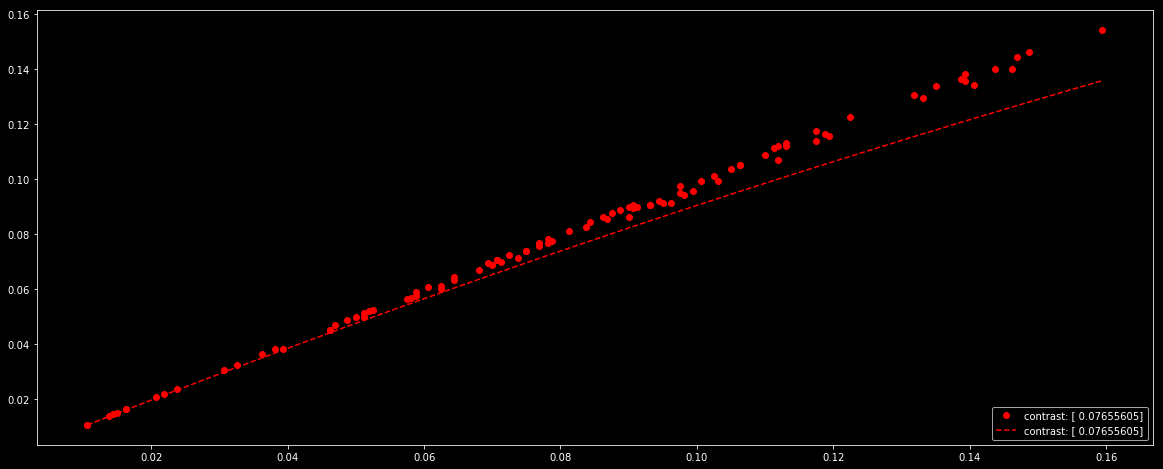

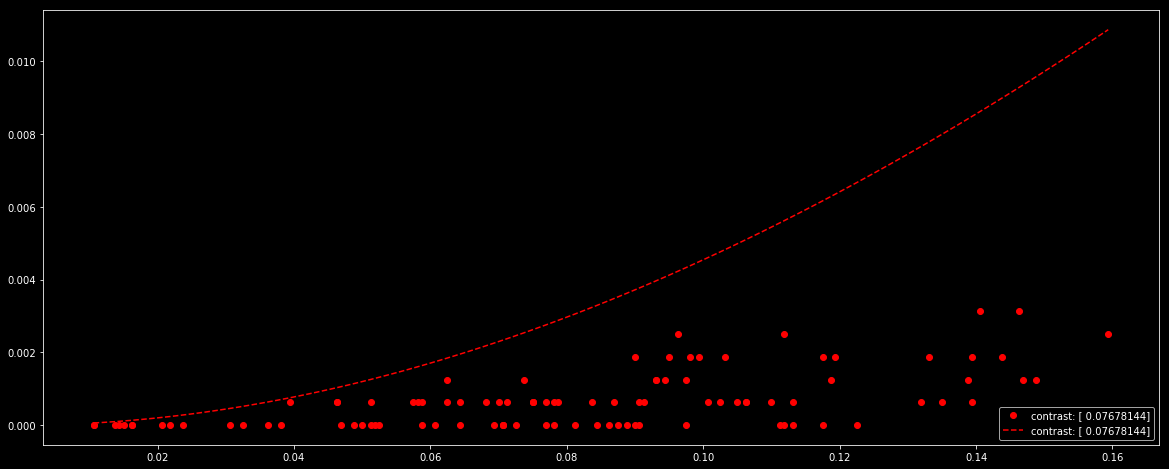

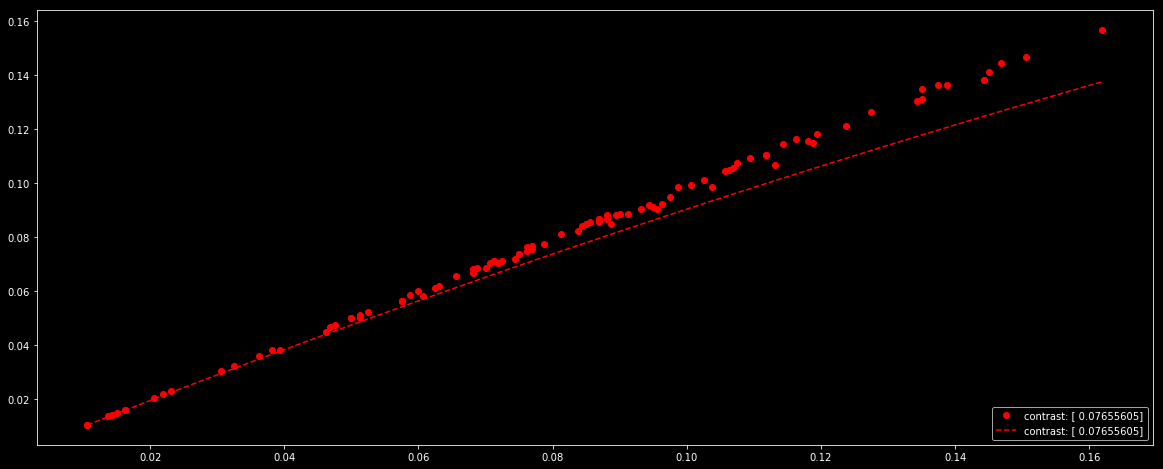

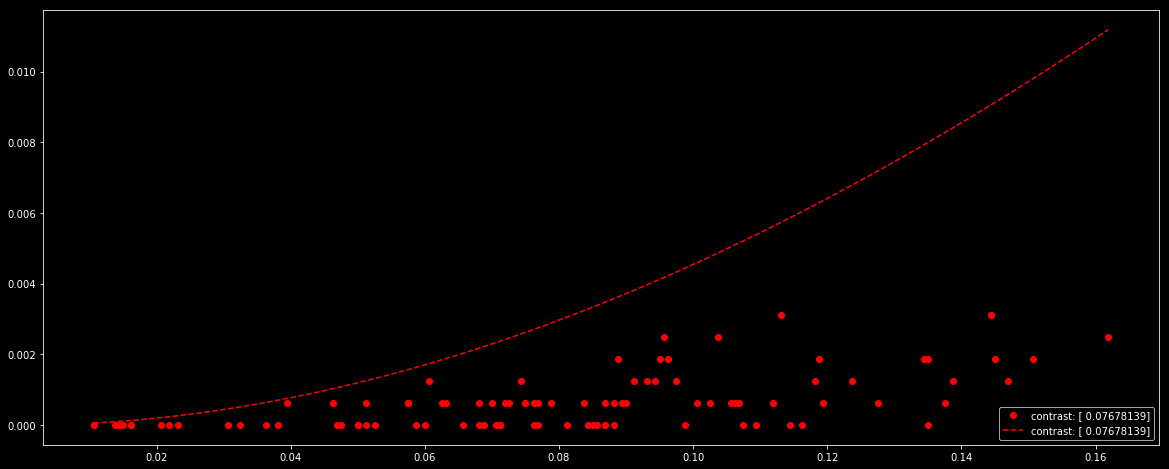

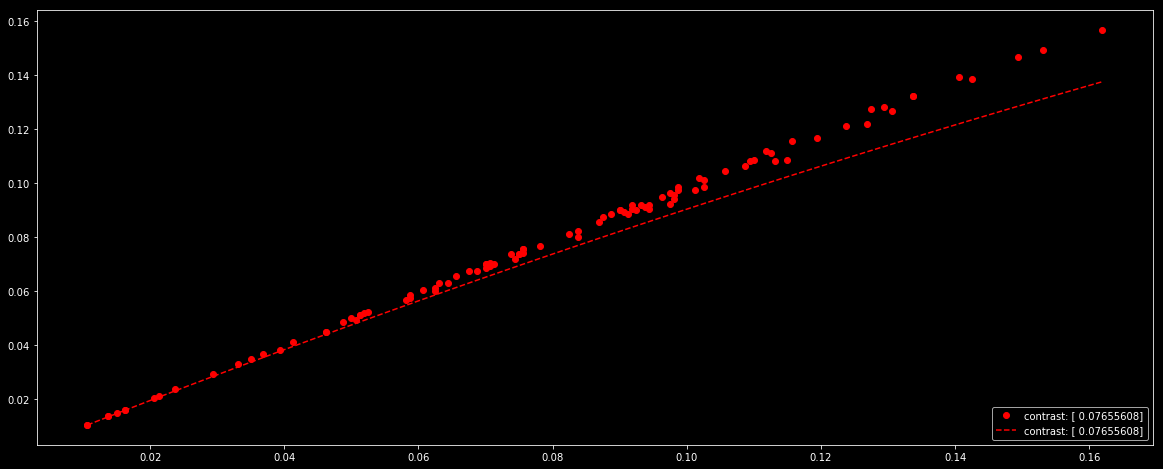

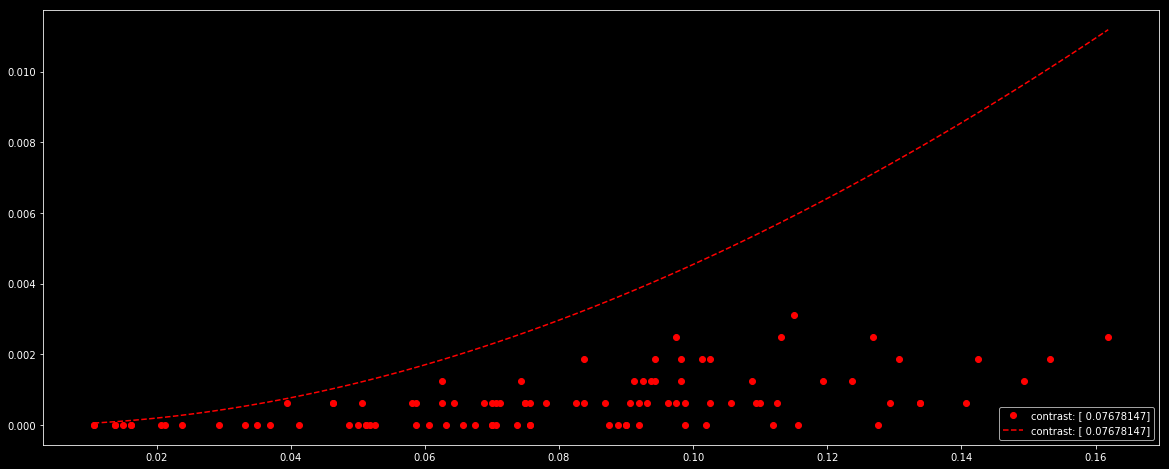

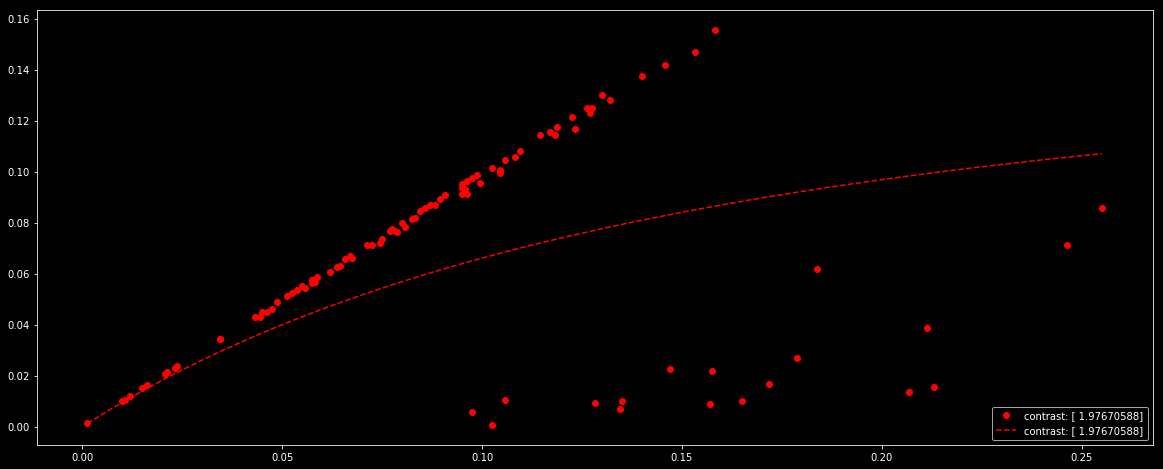

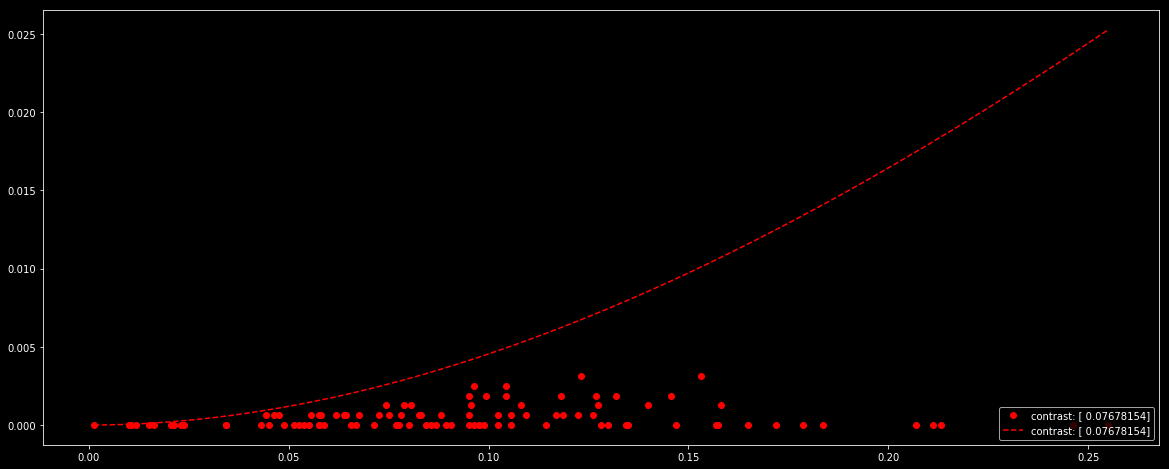

In [105]:
GGphotonMapings = np.asarray( GGphotonMapings )
nShots = 100

for ii in range(4):
    
    for k in [1,2]:
        Pk=[]
        kave=[] 

        for jj in range(nShots):
            img = GGphotonMapings[ii][jj]
            #img = simu_speckles[jj]
            Pk.append(np.sum(img==k).astype(float)/img.size)
            kave.append(np.sum(img).astype(float)/img.size)


        res = {'Pk': np.asarray(Pk),
              'kave': np.asarray(kave)}

        # Fit the first set
        fitfunc = lambda p, x: (gamma(k+p[0])/gamma(p[0])/factorial(k))*((x/(x+p[0]))**k)*((p[0]/(x+p[0]))**p[0])
        errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
        p0 = 0.4 # Initial guess for the parameters
        p1, success = optimize.leastsq(errfunc, p0, args=(res['kave'], res['Pk']))

        plt.figure()
        xx = np.linspace(res['kave'].min(),res['kave'].max(),100)
        plt.plot(res['kave'], res['Pk'], "ro", xx, fitfunc(p1, xx), "r--", label='contrast: {}'.format(np.array_str(1/np.sqrt(p1))), alpha=1)
        plt.legend(loc=4)

plt.show() 

In [92]:
def PhotonProbLSQfit( data, k ):
   
    Pk=[]
    kave=[] 
    res = []
    
    for jj in range( data.shape[0] ):
        img = data[jj]
        Pk.append(np.sum(img==k).astype(float)/img.size)
        kave.append(np.sum(img).astype(float)/img.size)


    res = {'Pk': np.asarray(Pk),
          'kave': np.asarray(kave)}

    # Fit the first set
    fitfunc = lambda p, x: (gamma(k+p[0])/gamma(p[0])/factorial(k))*((x/(x+p[0]))**k)*((p[0]/(x+p[0]))**p[0])
    errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
    p0 = 0.4 # Initial guess for the parameters
    p1, success = optimize.leastsq(errfunc, p0, args=(res['kave'], res['Pk']))
    res['p1'] = p1

    return res, fitfunc

For a sparse and non binned simulated speckled, the Greddy Guess can extract the contrast !!

Subplots options : https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.5.2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.5.2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in power


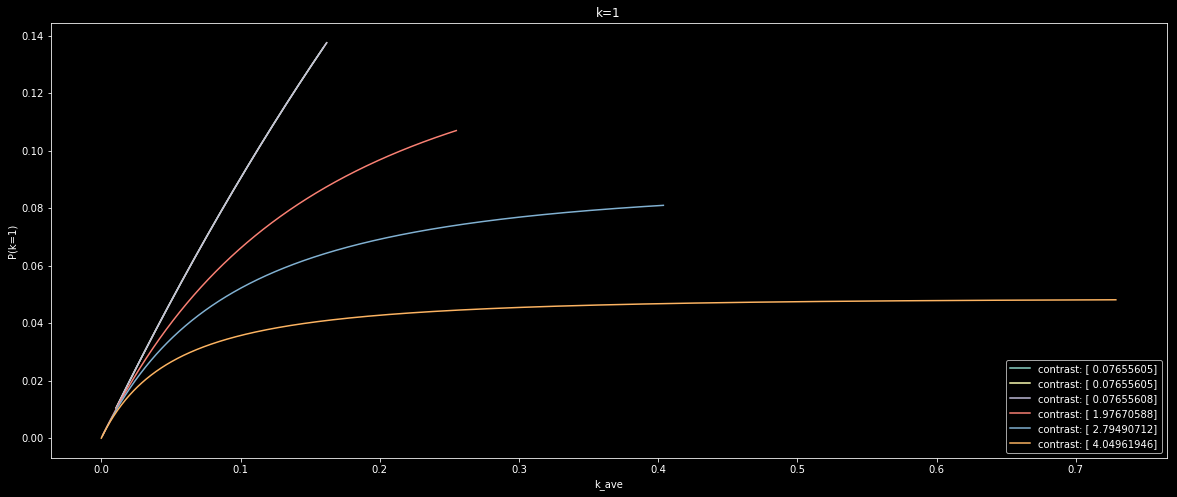

In [106]:
plt.figure()
ax1 = plt.subplot(1,1,1)
contrasts = []
k = 1

for ii in range(6):
        
        Fits, fitfunc = PhotonProbLSQfit( GGphotonMapings[ii], k)
       
        contrasts.append( 1/np.sqrt(Fits['p1']) )
        xx = np.linspace(Fits['kave'].min(),Fits['kave'].max(),1000)
        colour= ['b', 'g', 'r', 'y'],
        #plt.plot(res['kave'], res['Pk'], "ro", xx, fitfunc(p1, xx), "r--", label='contrast: {}'.format(np.array_str(1/np.sqrt(p1))), alpha=1)
        ax1.plot(xx, fitfunc(Fits['p1'], xx), label='contrast: {}'.format(np.array_str(1/np.sqrt(Fits['p1']))), alpha=1)
        ax1.set_ylabel('P(k={})'.format(str(k)))
        ax1.set_xlabel('k_ave')
        ax1.set_title('k='+str(k))
        ax1.legend(loc=4)
        
plt.show()